In [1]:
%pip install tensorflow numpy matplotlib pillow scikit-learn seaborn

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

Data Loading and Preprocessing

In [2]:
def load_binary_data(data_dir='dataset/Wound_dataset copy', img_size=(224, 224)):
    images = []
    labels = []
    
    # Process bruise images (positive class)
    bruise_path = os.path.join(data_dir, 'Bruises')
    if os.path.exists(bruise_path):
        for img_name in os.listdir(bruise_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(bruise_path, img_name)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img) / 255.0
                    
                    images.append(img_array)
                    labels.append(1)  # 1 for bruise
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    # Process normal skin images (negative class)
    normal_path = os.path.join(data_dir, 'Normal')
    if os.path.exists(normal_path):
        for img_name in os.listdir(normal_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(normal_path, img_name)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img) / 255.0
                    
                    images.append(img_array)
                    labels.append(0)  # 0 for normal
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

Load the dataset

In [3]:
X, y = load_binary_data()
print("Dataset shape:", X.shape)
print("Number of bruise images:", np.sum(y == 1))
print("Number of normal images:", np.sum(y == 0))

Dataset shape: (442, 224, 224, 3)
Number of bruise images: 242
Number of normal images: 200


Data Splitting

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)
print("\nData split sizes:")
print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")


Data split sizes:
Training set: 317 images
Validation set: 80 images
Test set: 45 images


Model Definition with L2 Regularization Only

In [5]:
def create_l2_model(input_shape, l2_lambda=0.001):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

input_shape = X_train[0].shape
model = create_l2_model(input_shape, l2_lambda=0.001)

Model Compilation

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Model Training

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5324 - loss: 21.1353 - precision: 0.5805 - recall: 0.6309 - val_accuracy: 0.5500 - val_loss: 8.7206 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 920ms/step - accuracy: 0.5084 - loss: 6.4897 - precision: 0.5214 - recall: 0.8134 - val_accuracy: 0.7000 - val_loss: 1.1582 - val_precision: 0.9167 - val_recall: 0.5000
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 887ms/step - accuracy: 0.7199 - loss: 1.0554 - precision: 0.7029 - recall: 0.8564 - val_accuracy: 0.7375 - val_loss: 1.0202 - val_precision: 0.9259 - val_recall: 0.5682
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 870ms/step - accuracy: 0.8702 - loss: 0.8870 - precision: 0.8993 - recall: 0.8762 - val_accuracy: 0.8250 - val_loss: 0.9167 - val_precision: 0.9167 - val_recall: 0.7500
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 843ms/step - accuracy: 0.9003 - loss: 0.8260 - precision: 0.9405 - recall: 0.8748 - val_accuracy: 0.8375 - val_loss: 0.8

Plot Training History (Accuracy/Loss/Precision/Recall)

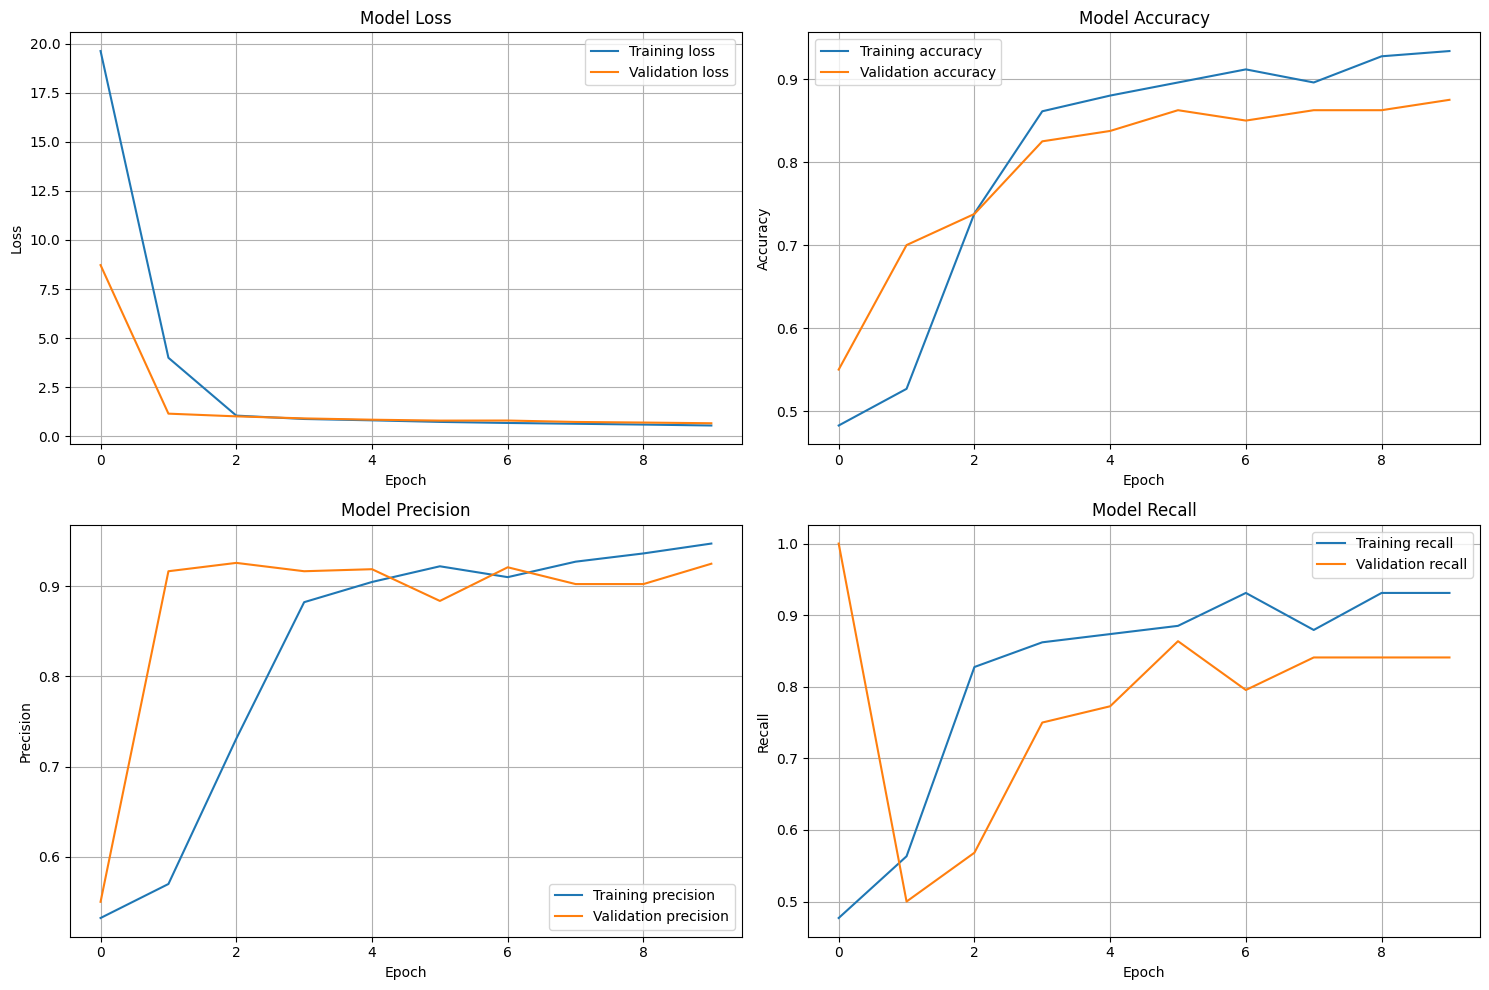

In [8]:
def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for idx, metric in enumerate(metrics):
        row = idx // 2
        col = idx % 2
        axes[row, col].plot(history.history[metric], label=f'Training {metric}')
        axes[row, col].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[row, col].set_title(f'Model {metric.capitalize()}')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(metric.capitalize())
        axes[row, col].legend()
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [9]:
# Print each metric
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

Test Loss: 0.6300
Test Accuracy: 0.8222
Test Precision: 0.8333
Test Recall: 0.8333


Model Evaluation on Test Set

In [10]:
# Predict probabilities and classes
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


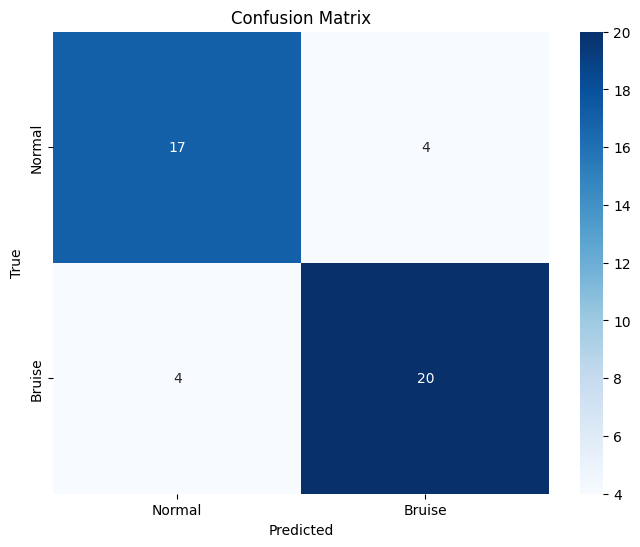

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Bruise'],
            yticklabels=['Normal', 'Bruise'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Bruise'], digits=4))


Classification Report:
              precision    recall  f1-score   support

      Normal     0.8095    0.8095    0.8095        21
      Bruise     0.8333    0.8333    0.8333        24

    accuracy                         0.8222        45
   macro avg     0.8214    0.8214    0.8214        45
weighted avg     0.8222    0.8222    0.8222        45



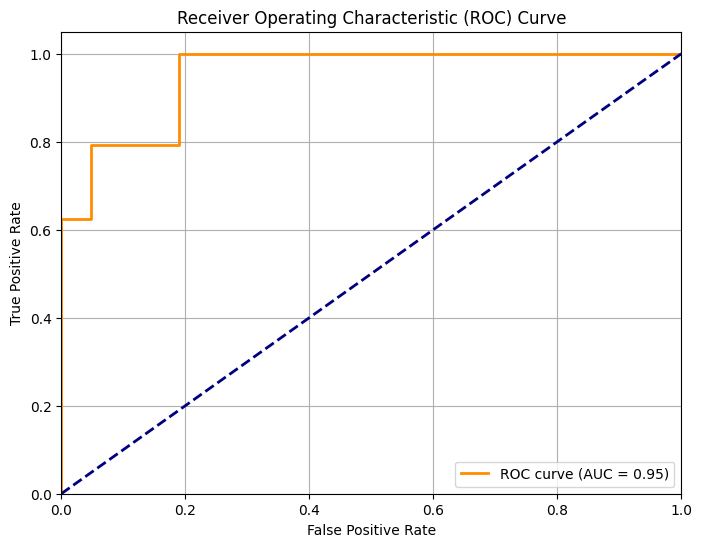

In [13]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Save the Model

In [14]:
model.save('models/bruise_detection_l2.h5')
print("Model saved as bruise_detection_l2.h5")

Model saved as bruise_detection_l2.h5
